[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/Evaluation.ipynb)

# Model Evaluation and Selection
Once we train our model on our dataset, we may hope that it also works well on unseen data. However, getting the best performance on our data is not a good measure. Instead of importing our implementation of `KNN`, to keep things simple, let's use `scikit-learn`'s implementation.

In [13]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
from sklearn import datasets, neighbors
# Set random seed for reproducibility
# This ensures we get the same random splits every time we run this notebook
np.random.seed(1234)

let's set aside 20% of the examples to test the performance of our model as we change the number of neighbours `K` in KNN regression.

In [14]:
# Load the California housing dataset
# This is a regression dataset predicting median house values
# x: features like average rooms, population, etc., shape (num_instances, num_features)
# y: target values (median house prices), shape (num_instances,)
x, y = datasets.fetch_california_housing(return_X_y=True)

# Get dataset dimensions
# x.shape returns a tuple (num_instances, num_features)
# Unpacking: num_instances gets first element, num_features gets second
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
print(num_instances, num_features, num_classes)

# Define Mean Squared Error (MSE) loss function
# This measures the average squared difference between predictions and true values
# y: true values, shape (N,)
# yh: predicted values (h stands for "hat", as in y-hat), shape (N,)
# Returns: scalar MSE value (lower is better)
loss = lambda y, yh: np.mean((y-yh)**2)

20640 8 6.00001


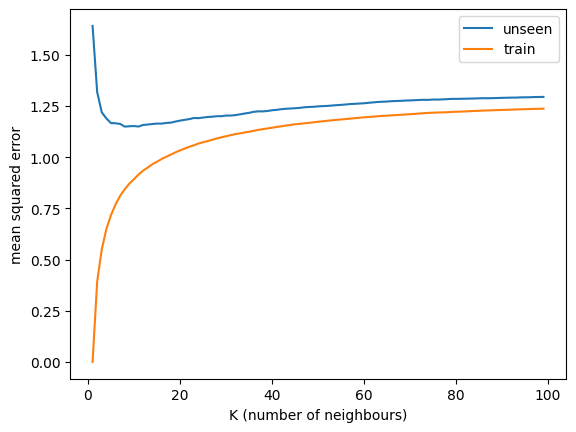

In [15]:
# Data split: divide dataset into training and test sets (80% train, 20% test)

# Calculate test set size: use integer division to get 20% of data
# Example: if num_instances = 20640, then n_test = 4128
n_test = num_instances // 5

# Create random permutation of indices to shuffle the dataset
# np.random.permutation(n) returns array [0, 1, ..., n-1] in random order
# This ensures random sampling without replacement
# inds shape: (num_instances,)
inds = np.random.permutation(num_instances)

# Advanced indexing: x[inds[n_test:]] selects rows in shuffled order
# inds[n_test:] gets indices from position n_test to end (80% of data)
# x[array_of_indices] selects rows corresponding to those indices
# x_train shape: (num_instances - n_test, num_features)
# y_train shape: (num_instances - n_test,)
x_train, y_train = x[inds[n_test:]], y[inds[n_test:]]

# inds[:n_test] gets first n_test indices (20% of data)
# x_test shape: (n_test, num_features)
# y_test shape: (n_test,)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]

# Evaluate model performance for different values of K (number of neighbors)
K_list = range(1,100)
# Initialize empty lists to store error values for each K
err_train, err_test = [], []

# Loop over different K values to find optimal hyperparameter
for i, K in enumerate(K_list):
    # Create KNN regressor with K neighbors
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    
    # Fit the model on training data
    # model.fit returns the fitted model (allows method chaining)
    model = model.fit(x_train, y_train)
    
    # Compute test error: error on unseen data
    # model.predict(x_test) returns predictions, shape (n_test,)
    err_test.append(loss(model.predict(x_test), y_test))
    
    # Compute training error: error on data used for training
    # Training error is typically lower than test error (model has seen this data)
    err_train.append(loss(model.predict(x_train), y_train))

# Plot training vs test error as K increases
# This shows the bias-variance tradeoff:
# - Small K: low bias, high variance (overfitting, low train error, high test error)
# - Large K: high bias, low variance (underfitting, both errors increase)
plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

The plot above shows that the best model according to our training data is not necessarily the best model when it comes to unseen data. 
What other observations can we make from the plot above?

## Generalization error
what we really care about is the performance of the model on new data.
In other words, we want to see how our model **generalizes** to unseen data. 
An assumption that justifies deployment of our model on unseen data is the fact that our training and deployment data come from the *same* distribution. In fact very often we assume that there exists some distribution $p(x,y)$ over our features and labels, such that our training data is composed of independent samples from this distribution -- that is $x^{(n)}, y^{(n)} \sim p(x, y)$ for all $x^{(n)}, y^{(n)} \in \mathcal{D}$. We assume that unseen data are also samples from the same distribution.

**Generalization error** is the *expected error* of our model $f: x \mapsto y$ under this distribution:
$$ 
Err(f) = \mathbb{E}_{x,y \sim p}[\ell(f(x), y)].
$$
Here $\ell$ is some *loss function* such as classification error $\ell(y, \hat{y}) = \mathbb{I}(y = \hat{y})$ or square loss $\ell(y, \hat{y}) = (y - \hat{y})^2$ that we often use in regression.

## Test set
Unfortunately, we don't have access to the true data distribution, we only have samples from this dataset. We can estimate the generalization error by setting aside a portion of our dataset that **we do not using in any way in learning or selecting the model**. This part of the dataset is called the **test set**. Let's use $\mathcal{D}_{\text{train}}$ and $\mathcal{D}_{\text{test}}$ to this partitioning of our original dataset $\mathcal{D}$. The **test error** is
$$
\widehat{Err}(f) = \mathbb{E}_{x, y \sim \mathcal{D}_{\text{test}}}[\ell(f(x), y)] = \frac{1}{|\mathcal{D}_{\text{test}}|} \sum_{x,y \in \mathcal{D}_{\text{test}}} \ell(f(x), y).
$$

## Validation set 
Suppose we want to tune the hyper-parameters of our model. We can use a similar idea for picking the best hyper-parameter. Ideally, we want to pick hyper-parameters that give us the best generalization error, or test error. However, it would be a mistake to adjust our model based on the test data; this could lead to overfitting to our test data, which means the performance on the test data is no longer an unbiased estimate of generalization error. So we can set aside another subset of our dataset for doing *model selection*. This is called the *validation set*, or *development set*.

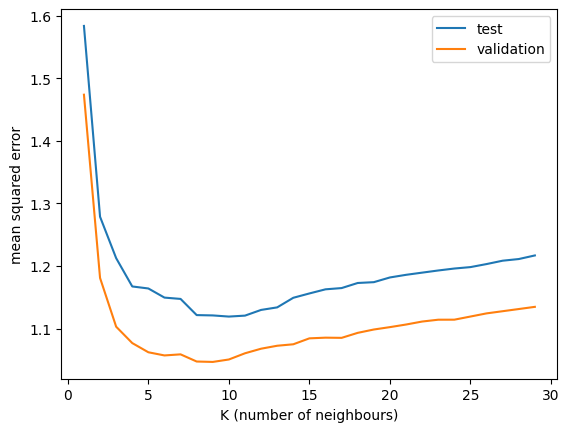

In [16]:
# Split data into three sets: train (80%), validation (10%), test (10%)
# This allows us to tune hyperparameters on validation set without touching test set

# Calculate sizes for test and validation sets (each 10% of data)
# Using integer division: num_instances // 10 gives us 10% of the data
n_test, n_valid = num_instances // 10, num_instances // 10

# Create new random permutation for this 3-way split
# inds shape: (num_instances,)
inds = np.random.permutation(num_instances)

# Advanced slicing to create three non-overlapping subsets:
# Test set: first 10% (indices 0 to n_test)
# inds[:n_test] selects first n_test indices
# x_test shape: (n_test, num_features)
# y_test shape: (n_test,)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]

# Validation set: next 10% (indices n_test to n_test+n_valid)
# inds[n_test:n_test+n_valid] selects middle slice
# x_valid shape: (n_valid, num_features)
# y_valid shape: (n_valid,)
x_valid, y_valid = x[inds[n_test:n_test+n_valid]], y[inds[n_test:n_test+n_valid]]

# Training set: remaining 80% (indices n_test+n_valid to end)
# inds[n_test+n_valid:] selects from offset to end
# x_train shape: (num_instances - n_test - n_valid, num_features)
# y_train shape: (num_instances - n_test - n_valid,)
x_train, y_train = x[inds[n_test+n_valid:]], y[inds[n_test+n_valid:]]

# Evaluate models with smaller range of K values (1 to 30)
K_list = range(1,30)

# Initialize lists to track errors on all three sets
err_train, err_test, err_valid = [], [], []

# For each K value, train on training set and evaluate on all three sets
for i, K in enumerate(K_list):
    # Create and fit KNN model with K neighbors
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train, y_train)
    
    # Test error: performance on held-out test set (NEVER used for model selection)
    err_test.append(loss(model.predict(x_test), y_test))
    
    # Validation error: used to select best K (hyperparameter tuning)
    # This is the key metric for model selection
    err_valid.append(loss(model.predict(x_valid), y_valid))
    
    # Training error: typically optimistic (model has seen this data)
    err_train.append(loss(model.predict(x_train), y_train))
    
# Plot test and validation errors to compare
# Note: We should select K based on validation error, then report final test error
plt.plot(K_list, err_test,  label='test')
# Training error commented out to reduce clutter in the plot
#plt.plot(K_list, err_train,  label='train')
plt.plot(K_list, err_valid, label='validation')

plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

### Cross validation 
Note that once we pick the best hyper-parameters for our model we can use both train+validation sets to retrain the model. This is only practical if training can be done efficiently.
In the figure above you can notice that validation error can be slightly different from the test error (simply re-run the code). This difference is due to the size of both validation and test sets. We can get a better estimate of the validation error and its variance using **cross validation**: the idea is to repeat the trainin-validation using a different portion of the data. Then we can use the mean and the variance of the training and validation error over these repetitions. For this, it is best to use non-overlapping validation sets: for example use, first we set asign 10% of the data for test. Then a 5-fold cross-validation, would divide the remaining 90% to 5 subsets. At each iteration of cross-validation, one of these 5 subsets will be used for validation and the remaining 4 will be used for training. Once we pick the best model using mean and variance of the validation error, we can train the model using the entire 90% of the data. Finally, we report the performance on the test set. Below we implement a method that returns train and validation split for cross-validation.

In [17]:
def cross_validate(n, n_folds=10):
    """
    Generator function for K-fold cross-validation splits.
    
    Divides n samples into n_folds non-overlapping folds. In each iteration,
    one fold is used for validation and the remaining folds for training.
    
    Parameters:
    n: total number of samples to split
    n_folds: number of folds (default 10)
    
    Yields:
    tr_inds: list of training indices
    val_inds: list of validation indices
    
    Example with n=100, n_folds=5:
    - Fold 0: train on [20-99], validate on [0-19]
    - Fold 1: train on [0-19, 40-99], validate on [20-39]
    - ...
    - Fold 4: train on [0-79], validate on [80-99]
    """
    # Calculate validation set size for each fold
    # Integer division ensures even split (last fold may be slightly larger)
    n_val = n // n_folds
    
    # Note: This line creates empty list (overwriting unused permutation)
    # The original line 'inds = np.random.permutation(n)' is not used
    inds = []
    
    # Iterate through each fold
    for f in range(n_folds):
        # Initialize empty training indices list
        tr_inds = []
        
        # Calculate validation indices for this fold
        # Fold f uses indices from [f*n_val, (f+1)*n_val)
        # Example: fold 2 with n_val=20 uses indices [40, 60)
        val_inds = list(range(f * n_val, (f+1)*n_val))
        
        # Build training indices from all OTHER folds
        # Training set = all indices except current validation fold
        
        # Add indices BEFORE current fold (folds 0 to f-1)
        if f > 0:
            # list(range(f*n_val)) creates [0, 1, ..., f*n_val-1]
            # These are all indices before the current validation fold
            tr_inds = list(range(f*n_val))
        
        # Add indices AFTER current fold (folds f+1 to n_folds-1)
        if f < n_folds - 1:
            # list(range((f+1)*n_val, n)) creates [(f+1)*n_val, ..., n-1]
            # Concatenate with existing tr_inds using + operator
            # These are all indices after the current validation fold
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        
        # The yield statement makes this a generator function
        # It suspends execution and returns (tr_inds, val_inds)
        # Next iteration resumes from here with the next fold
        # This is memory efficient: doesn't create all splits at once
        yield tr_inds, val_inds

Let's first set aside the test data

In [18]:
# Create random permutation of all data indices
# This shuffles the data before splitting
# inds shape: (num_instances,)
inds = np.random.permutation(num_instances)

# Separate the test data (first n_test samples after shuffling)
# Advanced indexing: inds[:n_test] selects first n_test shuffled indices
# x_test shape: (n_test, num_features)
# y_test shape: (n_test,)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]

# Keep remaining data for training and cross-validation
# inds[n_test:] selects all indices after n_test
# x_rest shape: (num_instances - n_test, num_features)
# y_rest shape: (num_instances - n_test,)
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]

# Calculate size of remaining data (for cross-validation)
# This will be split into n_folds during cross-validation
n_rest = num_instances - n_test

Then we use cross-validation to find the best set of hyper-parameters

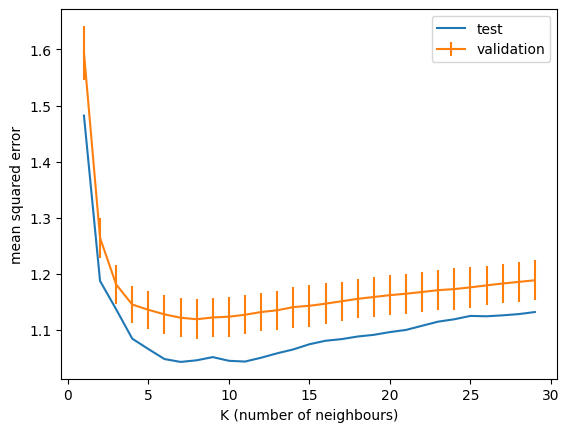

In [19]:
# Perform cross-validation to find the best K with error estimates
num_folds = 10

# Initialize arrays to store errors
# err_test: one error value per K, shape (len(K_list),)
# err_valid: one error per K per fold, shape (len(K_list), num_folds)
#            This 2D array lets us compute mean and std across folds
err_test, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))

# Outer loop: iterate over different K values (hyperparameter search)
for i, K in enumerate(K_list):
    # Inner loop: iterate over cross-validation folds
    # enumerate() gives both fold index (f) and the split (tr, val)
    # cross_validate() is a generator that yields training/validation indices
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        # Create KNN model with current K
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        
        # Train on training fold using advanced indexing
        # x_rest[tr] selects rows at indices in tr list
        # tr is a list of indices, x_rest[tr] selects those rows
        # Shape: x_rest[tr] is (len(tr), num_features)
        model = model.fit(x_rest[tr], y_rest[tr])
        
        # Evaluate on validation fold
        # val is a list of indices for validation samples
        # x_rest[val] selects validation samples, shape (len(val), num_features)
        # Store error in 2D array: row i is K value, column f is fold number
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))
    
    # After cross-validation, train final model on ALL remaining data
    # This gives best estimate for this K using all available training data
    # Note: In practice, we shouldn't compute test error until final model selection
    # This is shown here for demonstration purposes
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_rest, y_rest)
    
    # Compute test error (again, this should only be done ONCE at the very end)
    err_test[i]= loss(y_test, model.predict(x_test))

# Visualization with error bars showing uncertainty across folds
plt.plot(K_list, err_test,  label='test')

# Plot validation error with error bars
# np.mean(err_valid, axis=1): average across folds (axis 1), shape (len(K_list),)
#                            axis=1 means average across columns (folds)
# np.std(err_valid, axis=1): standard deviation across folds, shape (len(K_list),)
#                           This shows the uncertainty/variance of the estimate
# errorbar() draws vertical bars showing mean +/- std at each K
plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')

plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

A simple rule of thumb for picking the best model using cross-validation is to pick the simplest model that is within one standard deviation of the best performing model.
What if we have multiple hyper-parameters that should be optimized simultaneously? Some simple solutions are **grid-search** and **random-search** which exhustively or randomly search over joint assignments to hyper-parameters. 

## Evaluation metrics

One could use criteria that are potentially different from the objective in a classification or regression task to evaluate a model.
For example, while it may be easier to optimize mean squared error in regression, we may be eventually interested in the relative error $\frac{|\hat{y}-y|}{|y + \epsilon|}$. Note that "ideally" we should try to optimize the quantity we are interested in. While some measures may be hard to optimize we can use them in model selection; for example in picking the best hyper-parameter.

### Confusion matrix
For classification, we can better understand the behaviour of our classifier by producing the *confusion matrix*. It tells us how much items in one class (rows) are assigned to another class by a classifier (columns). Let's use `scikit-learn`'s implementation of decision tree to learn a classifier.

In [20]:
from sklearn import tree, model_selection

# Load the Iris dataset for classification
# x: features (sepal/petal dimensions), shape (150, 4)
# y: class labels (0, 1, or 2), shape (150,)
x, y = datasets.load_iris(return_X_y=True)

# Split into train (80%) and test (20%) sets
# test_size=0.2 means 20% of data goes to test set
# This function randomly shuffles and splits the data
# Returns: x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

# Train a decision tree classifier and make predictions
# Method chaining: .fit() returns fitted model, .predict() returns predictions
# yh_test: predicted class labels for test set, shape (30,) approximately
yh_test = tree.DecisionTreeClassifier().fit(x_train, y_train).predict(x_test)

Now let's calculate the confusion matrix

In [21]:
def confusion_matrix(y, yh):
    """
    Compute confusion matrix for multi-class classification.
    
    The confusion matrix shows how predictions compare to true labels.
    Rows represent true classes, columns represent predicted classes.
    Element [i,j] = number of samples with true class i predicted as class j.
    
    Parameters:
    y: true class labels, shape (N,)
    yh: predicted class labels, shape (N,)
    
    Returns:
    c_matrix: confusion matrix, shape (n_classes, n_classes)
    
    Example for binary classification:
                 Predicted
                 0    1
    True  0  [[TN   FP]
          1   [FN   TP]]
    """
    # Calculate number of classes
    # np.max(y) + 1 assumes classes are labeled 0, 1, ..., K-1
    n_classes = np.max(y) + 1
    
    # Initialize confusion matrix with zeros
    # Shape: (n_classes, n_classes)
    c_matrix = np.zeros((n_classes, n_classes))
    
    # Nested loops to count predictions for each (true_class, predicted_class) pair
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            # Boolean arithmetic to count matching conditions
            # (y==c1) creates boolean array: True where true label is c1, shape (N,)
            # (yh==c2) creates boolean array: True where prediction is c2, shape (N,)
            # * operator: element-wise multiplication (AND operation)
            #   Result is 1 when both conditions true, 0 otherwise
            # np.sum() counts total number of True values (sum of 1s)
            # This counts: samples with true class c1 predicted as c2
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    
    return c_matrix

# Compute and display confusion matrix
cmat = confusion_matrix(y_test, yh_test)
print(cmat)

# Calculate accuracy from confusion matrix
# Diagonal elements: correctly classified samples (true class = predicted class)
# np.diag(cmat) extracts diagonal: [cmat[0,0], cmat[1,1], cmat[2,2]]
# np.sum(np.diag(cmat)): total correct predictions
# np.sum(cmat): total number of samples
# Accuracy = (correct predictions) / (total samples)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

[[11.  0.  0.]
 [ 0.  7.  1.]
 [ 0.  2.  9.]]
accuracy: 0.9


For **binary classification**, the four elements of the confusion table give us
- true-positive (TP)
- true-negative (TN)
- false-positive (FP)
- false negative (FN)
As before **accuracy** is the sum of diagonal elements divided by the whole matrix. Various quantities such as false positive rate, precision, recall and false discovery rate are calcusted from these four values.